# ChainerによるMNIST(MLP、CNN)

## MLP

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
#from chainer import serializers
# import cPickle as pickle # hdf5のインストールがめんどいからpickleでシリアライズ

/Users/Shintaro/.pyenv/versions/miniconda3-4.3.11/envs/Liaro/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


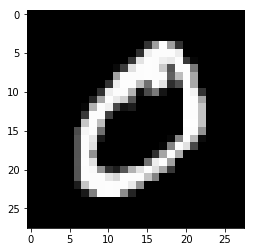

In [2]:
# mnistをDL
mnist = fetch_mldata("MNIST original") #, data_home="./data")

# データをロード
x = mnist.data # (700000, 784) => 28x28(784)の画像が70000枚
y = mnist.target # (70000, ) one-hotではない
x = x.astype(np.float32)
y = y.astype(np.int32)

# 内容を確認
plt.imshow(x[0].reshape((28,28)), cmap=plt.cm.gray) # (28, 28)に変換してグレースケールで表示
plt.show()

In [3]:
# 輝度を揃える
print(x.max())
x /= x.max()
print(x.max())

255.0
1.0


In [4]:
#データを「学習データ:テストデータ=9:1」に分ける
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

# (データ数, チャネル数(色数), 縦, 横)の形式にする
x_train=x_train.reshape((x_train.shape[0], 1, 28, 28))
x_test=x_test.reshape((x_test.shape[0], 1, 28, 28))

# 実験の各パラメータ
batchsize = 100 # バッチサイズ。何個のデータをまとめて学習するか
epoch = 20 # エポック数。訓練をデータセット何週分するか
n_units = 100 # MLPの中間層の数。

In [6]:
def train(model, optimizer, x_data, y_data, batchsize=10):
    N = x_data.shape[0]
    perm = np.random.permutation(N) # 学習する順番をランダムに入れ替え
    
    sum_accuracy = 0    # 累計正答率
    sum_loss = 0        # 累計誤差
    start = time.time() # 開始時刻
    
    # batchsize個ずつ学習
    for i in tqdm(range(0, N, batchsize)):
        x = chainer.Variable(np.asarray(x_data[i:i + batchsize]))
        t = chainer.Variable(np.asarray(y_data[i:i + batchsize]))

        # パラメータの更新(学習)
        optimizer.update(model, x, t)
        
        sum_loss += float(model.loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)
        
    end = time.time() # 終了時刻
    elapsed_time = end - start
    throughput = N / elapsed_time # 単位時間当たりの作業量
    print("train mean loss={}, accuracy={}, throughput={} image/sec".format(sum_loss / N, sum_accuracy / N, throughput))

In [7]:
def evaluate(model, x_data, y_data, batchsize=10):
    N = x_data.shape[0]
    perm = np.random.permutation(N) # 学習する順番をランダムに入れ替え
    
    sum_accuracy = 0    # 累計正答率
    sum_loss = 0        # 累計誤差
    
    # batchsize個ずつ評価
    for i in tqdm(range(0, N, batchsize)):
        # 評価の時はvolatile
        x = chainer.Variable(np.asarray(x_data[i:i + batchsize]))
        t = chainer.Variable(np.asarray(y_data[i:i + batchsize]))
        
        # 評価
        loss = model(x, t)
        sum_loss += float(loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)
        
    print("test mean loss={}, accuracy={}".format(
        sum_loss / N, sum_accuracy / N))

## MLP

In [8]:
class MnistMLP(chainer.Chain):
    def __init__(self, n_units):
        super(MnistMLP, self).__init__(
            l1=L.Linear(None, n_units),
            l2=L.Linear(n_units, n_units),
            l3=L.Linear(n_units, 10),
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [9]:
mlp = L.Classifier(MnistMLP(1000))
optimizer = optimizers.Adam()
optimizer.setup(mlp)

In [ ]:
# train MLP
n_epoch = 10 # 学習回数(学習データを何周するか)
for epoch in range(1, n_epoch + 1):
    print("epoch", epoch)
    
    # 訓練
    train(mlp, optimizer, x_train, y_train, batchsize=100)
    
    # 評価
    evaluate(mlp, x_test, y_test, batchsize=100)

## CNN

### 畳み込み層
links.Convolution2D(入力チャネル数(RGBなら3)，出力フィルタ数， カーネルサイズ， ストライド(デフォルト1)， パディング(デフォルト0)，・・・）  
割り切れないとダメ
http://docs.chainer.org/en/stable/reference/generated/chainer.links.Convolution2D.html

In [11]:
x = np.arange(10 * 3 * 28 * 28, dtype=np.float32).reshape(10, 3, 28, 28)
print(x.shape)

conv = L.Convolution2D(3, 16, 3, pad=1)
x_conv = conv(x)

print(x_conv.shape)

(10, 3, 28, 28)
(10, 16, 28, 28)


### プーリング層
funtions.max_pooling_2d(入力，カーネルサイズ，ストライド，パディング
奇数だと最後は空を0とみなす

In [13]:
size = 11
x = np.arange(10 * 16 * size* size, dtype=np.float32).reshape(10, 16, size, size)
print(x.shape)

x_pool = F.max_pooling_2d(x, 2)
print(x_pool.shape)

(10, 16, 11, 11)
(10, 16, 6, 6)


In [15]:
32*7*7

1568

In [16]:
class CNN(chainer.Chain):
    def __init__(self):
        super(CNN, self).__init__(
            conv1=L.Convolution2D(1, 16, 3, pad=1),  # (入力チャンネル数、出力チャンネル数、フィルタサイズ)
            conv2=L.Convolution2D(16, 32, 3, pad=1),
            l1=L.Linear(32*7*7, 2*32*7*7),
            l2=L.Linear(2*32*7*7, 10)
        )
        
    def __call__(self, x):
        # 以下のような変換が必要
        x.data = x.data.reshape((len(x.data), 1, 28, 28))

        h = F.relu(self.conv1(x)) # (16, 28, 28)
        h = F.max_pooling_2d(h, 2) # (16, 14, 14)
        h = F.relu(self.conv2(h)) # (32, 14, 14)
        h = F.max_pooling_2d(h, 2) # (32, 7, 7)
        h = F.dropout(F.relu(self.l1(h)))
        y = self.l2(h)
        return y

In [18]:
# train CNN
cnn = L.Classifier(CNN())
optimizer = optimizers.Adam()
optimizer.setup(mlp)

# train MLP
n_epoch = 1 # 学習回数(学習データを何周するか)
for epoch in range(1, n_epoch + 1):
    print("\nepoch", epoch)
    
    # 訓練
    train(cnn, optimizer, x_train, y_train, batchsize=100)
    
    # 評価
    evaluate(cnn, x_test, y_test, batchsize=100)

  0%|          | 0/630 [00:00<?, ?it/s]


epoch 1


  1%|▏         | 1/70 [00:00<00:07,  9.39it/s]

train mean loss=2.3632889263213626, accuracy=0.08925396852668316, throughput=357.575326383765 image/sec


100%|██████████| 70/70 [00:07<00:00,  9.29it/s]

test mean loss=2.360305496624538, accuracy=0.09071428584200995
